### **Imports and Configurations:**

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from ast import literal_eval

from utilities.utils import print_as_table

In [2]:
warnings.filterwarnings('ignore')

### **Loading Data:**

In [3]:
credits_df = pd.read_csv("./data/tmdb_5000_credits.csv")
info_df = pd.read_csv("./data/tmdb_5000_movies.csv")

#### Combining Dataframes:
**NOTE:** First, we have to check if given IDs are indeed unique before merging the two dataframes to avoid conflicts

In [4]:
# Checking whether id columns are unique
print(f"Credits Shape: {list(credits_df.shape)}")
print(f"Info Shape: {list(info_df.shape)}", end="\n\n")


print(f"All IDs in the credits dataframe are unique: {credits_df['movie_id'].nunique() == len(credits_df)}")
print(f"All IDs in the info dataframe are unique: {info_df['id'].nunique() == len(info_df)}", end='\n\n')

# Merging dataframes
movies_df = credits_df.merge(info_df, left_on='movie_id', right_on='id', how='outer').drop(columns=['id', 'title_y', 'original_title'])
movies_df.rename(columns={'title_x': 'title',
                          }, inplace=True)
movies_df.head()

Credits Shape: [4803, 4]
Info Shape: [4803, 20]

All IDs in the credits dataframe are unique: True
All IDs in the info dataframe are unique: True



,movie_id,title,cast,crew,budget,genres,homepage,keywords,original_language,overview,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,5,Four Rooms,"[{""cast_id"": 42, ""character"": ""Ted the Bellhop...","[{""credit_id"": ""52fe420dc3a36847f800012d"", ""de...",4000000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 35, ""name...",NaN,"[{""id"": 612, ""name"": ""hotel""}, {""id"": 613, ""na...",en,It's Ted the Bellhop's first night on the job....,...,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-09,4300000,98.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Twelve outrageous guests. Four scandalous requ...,6.5,530
1,11,Star Wars,"[{""cast_id"": 3, ""character"": ""Luke Skywalker"",...","[{""credit_id"": ""52fe420dc3a36847f8000437"", ""de...",11000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",http://www.starwars.com/films/star-wars-episod...,"[{""id"": 803, ""name"": ""android""}, {""id"": 4270, ...",en,Princess Leia is captured and held hostage by ...,...,"[{""name"": ""Lucasfilm"", ""id"": 1}, {""name"": ""Twe...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1977-05-25,775398007,121.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"A long time ago in a galaxy far, far away...",8.1,6624
2,12,Finding Nemo,"[{""cast_id"": 8, ""character"": ""Marlin (voice)"",...","[{""credit_id"": ""52fe420ec3a36847f80006b1"", ""de...",94000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",http://movies.disney.com/finding-nemo,"[{""id"": 494, ""name"": ""father son relationship""...",en,"Nemo, an adventurous young clownfish, is unexp...",...,"[{""name"": ""Pixar Animation Studios"", ""id"": 3}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-05-30,940335536,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"There are 3.7 trillion fish in the ocean, they...",7.6,6122
3,13,Forrest Gump,"[{""cast_id"": 7, ""character"": ""Forrest Gump"", ""...","[{""credit_id"": ""52fe420ec3a36847f800076b"", ""de...",55000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",NaN,"[{""id"": 422, ""name"": ""vietnam veteran""}, {""id""...",en,A man with a low IQ has accomplished great thi...,...,"[{""name"": ""Paramount Pictures"", ""id"": 4}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-07-06,677945399,142.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"The world will never be the same, once you've ...",8.2,7927
4,14,American Beauty,"[{""cast_id"": 6, ""character"": ""Lester Burnham"",...","[{""credit_id"": ""52fe420ec3a36847f8000809"", ""de...",15000000,"[{""id"": 18, ""name"": ""Drama""}]",http://www.dreamworks.com/ab/,"[{""id"": 255, ""name"": ""male nudity""}, {""id"": 29...",en,"Lester Burnham, a depressed suburban father in...",...,"[{""name"": ""DreamWorks SKG"", ""id"": 27}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1999-09-15,356296601,122.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Look closer.,7.9,3313


### **Exploring the data:**

In [5]:
print("Data Columns:")
print_as_table(movies_df.columns, 5)
print(f"Data Shape: {movies_df.shape}", end="\n\n")
print(f"NaN Counts:\n{movies_df.isna().sum()}", end="\n\n")
print(f"Unique Value Counts:\n{movies_df.nunique()}", end="\n\n")
print(f"Dataset Description:\n{movies_df.describe()}", end="\n\n")

Data Columns:
| movie_id | title | cast | crew | budget |
| genres | homepage | keywords | original_language | overview |
| popularity | production_companies | production_countries | release_date | revenue |
| runtime | spoken_languages | status | tagline | vote_average |
| vote_count |

Data Shape: (4803, 21)

NaN Counts:
movie_id                   0
title                      0
cast                       0
crew                       0
budget                     0
genres                     0
homepage                3091
keywords                   0
original_language          0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
vote_average               0
vote_count                 0
dtype: int64

Unique Value Counts:
movie_id                4803
ti

### **Cleaning Numerical Columns:**

#### Managing Wrong Values:
Although columns like `budget` and `revenue` can be zero, it doesn't make sense for the `runtime` column to be zero. movies with zero runtime are removed from the dataset!

In [6]:
zero_count = (movies_df['runtime'] == 0).sum()
print(f"Number of movies with zero runtime: {zero_count}")

# Set to nan
movies_df.loc[movies_df['runtime'] == 0, 'runtime'] = np.nan

Number of movies with zero runtime: 35


#### Managing Missing Values:
We replace missing values in `homepage` and `tagline` columns with empty strings, just in case we need them in the future.

The runtime column has some nan values which can be imputed statistically usnig the mean.

The rest of missing values are minimal and can be removed from dataset without any compromise.

In [7]:
movies_df['homepage'] = movies_df['homepage'].fillna('')
movies_df['tagline'] = movies_df['tagline'].fillna('')

movies_df['runtime'].fillna(movies_df['runtime'].mean(), inplace=True)

movies_df = movies_df.dropna()

#### Managing Outliers:
We use a z-score of 3.5 as the outlier threshold. 

In [8]:
numeric_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
z_scores = np.abs(zscore(movies_df[numeric_cols]))
mask = (z_scores < 3.5).all(axis=1)
new_movies_df = movies_df[mask]

print(f"Numeric Columns: {list(numeric_cols)}", end="\n\n")
print(f"New Data Shape: {new_movies_df.shape}", end="\n\n")
print(f"Number of Detected Outliers: {len(movies_df) - len(new_movies_df)}")

Numeric Columns: ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

New Data Shape: (4520, 21)

Number of Detected Outliers: 279


#### **Plotting Changes After Removing Outliers:** 
This is a histogram of each column before and after removing outliers:

Column 'budget' Skewness with outliers: 2.436114996530251
                        without outliers: 1.8284706706406866
Column 'popularity' Skewness with outliers: 9.721300885675499
                        without outliers: 1.7102527891685373
Column 'revenue' Skewness with outliers: 4.44312850497165
                        without outliers: 2.5163613512898606
Column 'runtime' Skewness with outliers: 1.830701174438494
                        without outliers: 0.9139991423874185
Column 'vote_average' Skewness with outliers: 1.941961006368368
                        without outliers: 0.5973033575131518
Column 'vote_count' Skewness with outliers: 3.8227043564784267
                        without outliers: 2.568523151578803


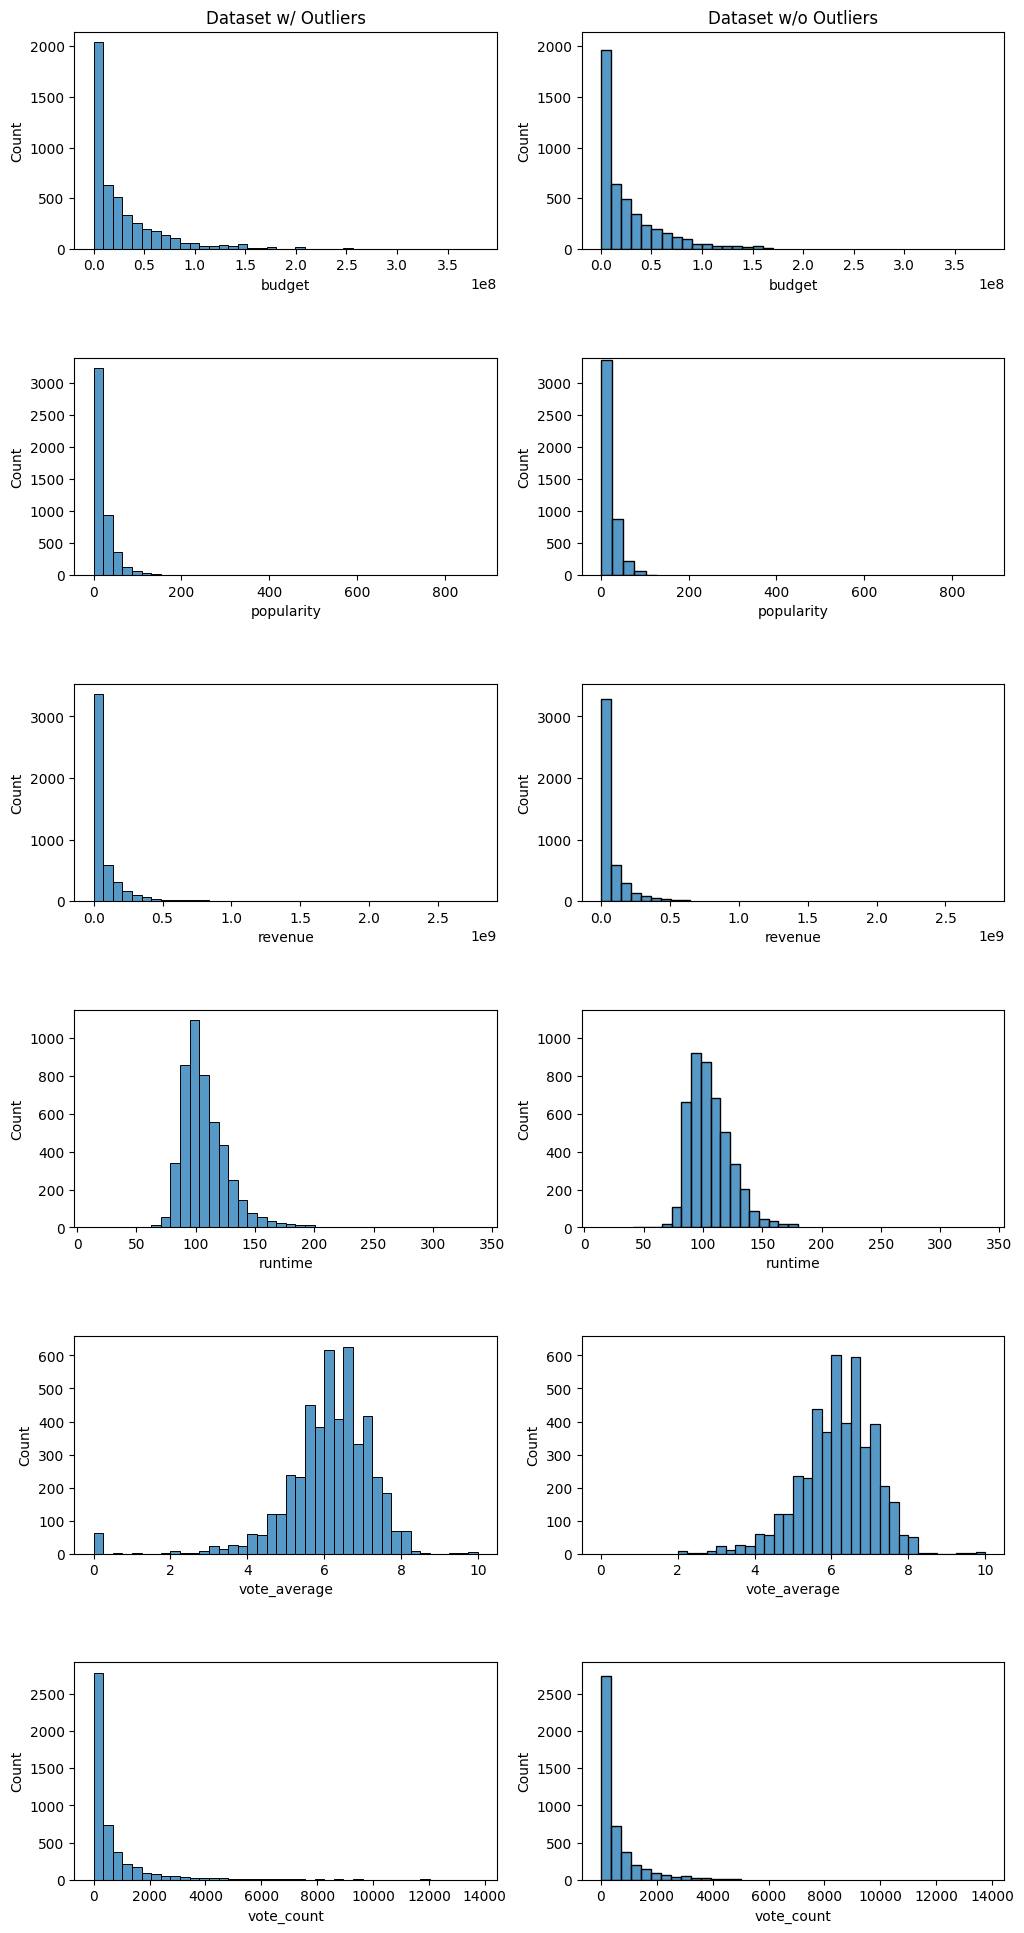

In [9]:
numeric_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
fig, axes = plt.subplots(6,2, figsize=(12,24))
plt.subplots_adjust(hspace=.5)
axes[0, 0].set_title('Dataset w/ Outliers')
axes[0, 1].set_title('Dataset w/o Outliers')
for idx, col in enumerate(numeric_cols):
    print(f"Column '{col}' Skewness with outliers: {abs(movies_df[col].skew())}")
    print(f"                        without outliers: {abs(new_movies_df[col].skew())}")

    col_range = np.ptp(movies_df[col])
    new_col_range = np.ptp(new_movies_df[col])
    bin_width = col_range / 40
    new_num_bins = int(new_col_range // bin_width)

    sns.histplot(data=movies_df, x=col, ax=axes[idx, 0], bins=40)
    sns.histplot(data=new_movies_df, x=col, ax=axes[idx, 1], bins=new_num_bins)

    xlim = axes[idx, 0].get_xlim()
    ylim = axes[idx, 0].get_ylim()
    axes[idx, 1].set_xlim(xlim)
    axes[idx, 1].set_ylim(ylim)

### **Cleaning Non-numerical Columns:**

#### Creating a dataframe of the cast:
In this step, we create a separate dataframe for the cast of each movie. 

In [20]:
# Creating a Casts Dataframe
cast_df = new_movies_df[['movie_id', 'revenue','cast']]
cast_df['cast'] = cast_df['cast'].apply(literal_eval)
cast_df = cast_df.explode('cast').reset_index(drop=True)


'Number of movies with less than 5 cast: ' +  str((cast_df.groupby('movie_id').count() < 5)['cast'].sum()), \
'Number of movies with less than 3 cast: ' +  str((cast_df.groupby('movie_id').count() < 3)['cast'].sum())

('Number of movies with less than 5 cast: 138',
 'Number of movies with less than 3 cast: 42')

In [11]:
# Removing excess information about the cast
cast_df['cast_id'] = cast_df['cast'].apply(lambda x: x.get('id') if isinstance(x, dict) else None)
cast_df['cast_name'] = cast_df['cast'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
cast_df['order'] = cast_df['cast'].apply(lambda x: x.get('order') if isinstance(x, dict) else None)

print(f"NaN Counts (REMOVED):\n{cast_df.isna().sum()}")

new_cast_df = cast_df.drop(columns=['cast', 'revenue']).dropna()
cast_df['cast_id'] = cast_df['cast_id']
new_cast_df

NaN Counts (REMOVED):
movie_id      0
revenue       0
cast         23
cast_id      23
cast_name    23
order        23
dtype: int64


,movie_id,cast_id,cast_name,order
0,5,3129.0,Tim Roth,0.0
1,5,3131.0,Antonio Banderas,1.0
2,5,3130.0,Jennifer Beals,2.0
3,5,3125.0,Madonna,3.0
4,5,3141.0,Marisa Tomei,4.0
...,...,...,...,...
95596,426469,1505855.0,Paul Castro Jr.,18.0
95597,426469,1744340.0,Edward Prostak,19.0
95598,426469,1506479.0,Deema Aitken,20.0
95599,426469,1085656.0,Laurie Dawn,21.0


**NOTE:** Since the number of movies with less than 5 cast members is insignificant, we will have the top 5 members of the cast in our analytical process.

#### Choosing top 5 cast members to include in the data:
For this purpose, we can either rank actors by the average of revenues of their movies or by the provided order in tmdb.

First we examine the first method:

In [12]:
cast_rankings = cast_df[['cast_id', 'revenue']].groupby('cast_id').mean('revenue')
cast_rankings = cast_rankings.sort_values(by='revenue', ascending=False).reset_index()
cast_rankings

,cast_id,revenue
0,33190.0,649398328.0
1,33188.0,649398328.0
2,1427944.0,649398328.0
3,131634.0,649398328.0
4,1427935.0,649398328.0
...,...,...
50255,1605092.0,0.0
50256,1605353.0,0.0
50257,1605499.0,0.0
50258,1605500.0,0.0


As it can be seen, this method puts too much of a high value on side characters of super successful movies, which is not convenient.

Therefore, we will use the provided order.

**NOTE:** Since the dataframe is not clean and orders don't necessarily contain 0 through 4, we have to extract the minimum manually 5 times.

In [13]:
top_casts_df = new_cast_df.where(new_cast_df['order'] <= 4.0).dropna()
cast_movie_df = new_movies_df

for idx in range(5):
    top_idx = top_casts_df.groupby('movie_id')['order'].idxmin()
    top = top_casts_df.loc[top_idx]
    cast_movie_df = pd.merge(cast_movie_df, top, on='movie_id', how='left').drop(columns=['cast_id', 'order']).rename(columns={'cast_name': f"actor_name_{idx+1}"})
    top_casts_df = top_casts_df[~top_casts_df.isin(top)].dropna()

cast_movie_df.isna().sum()

movie_id                  0
title                     0
cast                      0
crew                      0
budget                    0
genres                    0
homepage                  0
keywords                  0
original_language         0
overview                  0
popularity                0
production_companies      0
production_countries      0
release_date              0
revenue                   0
runtime                   0
spoken_languages          0
status                    0
tagline                   0
vote_average              0
vote_count                0
actor_name_1             25
actor_name_2             35
actor_name_3             47
actor_name_4            105
actor_name_5            401
dtype: int64

### **Saving Clean Dataset:**

In [14]:
new_movies_df.to_csv('./data/movies_data.csv')